# Хакатоним ФинТех

## Содержание

- [Загрузка библиотек](#ch1)
- [Сбор и анализ данных](#ch2)
    - [Загрузка данных](#ch21)
    - [Анализ тренировочной выборки](#ch22)
      - [df_train](#ch221)
          - [Первичный анализ](#ch2211)
          - [Приведение категориальных признаков к числовому виду](#ch2212)
          - [Заполнение пропусков](#ch2213)
      - [df_socdem](#ch222)
          - [Первичный анализ](#ch2221)
          - [Приведение категориальных признаков к числовому виду](#ch2222)
          - [Заполнение пропусков](#ch2223)
      - [df_balance](#ch223)
          - [Первичный анализ](#ch2231)
          - [Заполнение пропусков](#ch2233)
      - [df_stories_texts](#ch224)
          - [Первичный анализ](#ch2241)
          - [Заполнение пропусков](#ch2243)
      - [df_stories_logs](#ch225)
          - [Первичный анализ](#ch2251)
          - [Приведение категориальных признаков к числовому виду](#ch2252)
          - [Заполнение пропусков](#ch2253)
      - [df_products](#ch226)
          - [Первичный анализ](#ch2261)
          - [Заполнение пропусков](#ch2263)
- [Создание единой таблицы](#ch3)
- [Визуализация данных КАМРОН](#ch4)
- [Стандартизация признаков](#ch7)
- [Создание новых признаков](#ch9)
- [Кластеризация АЛИНА](#ch10)
- [Выбор бизнес-метрики](#ch11)
- [Метрики задач машинного обучения, соответствующие цели задачи](#ch12)
- [Предсказательная модель](#ch13)
    - [Multi-output regressor](#ch131)
- [Тестирование модели на тестовых данных](#ch15)
- [Возможные улучшения](#ch15)
- [Вывод](#ch16)

## Загрузка библиотек  <a class="anchor" id="ch1"></a>

In [2]:
!pip install pingouin

In [18]:
from IPython import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from sklearn import preprocessing
import statistics
from tqdm import tqdm
pd.set_option('display.max_rows', 500)

In [28]:

def removing_outliers(column,frame, count = 0,total_outliers = 0,is_tqdm = True):
        """
        Метод удаления выбросов с помощью межквартильного размаха
        """
        if is_tqdm:
            counter = tqdm
        else:
            counter = list()
        # Получим квантиль 25%
        q25=np.array(frame[column].describe(percentiles=[.25,.75]).loc['25%'])
        # Получим квантиль 75%
        q75=np.array(frame[column].describe(percentiles=[.25,.75]).loc['75%'])
        # Получим первую границу
        first_part=q25-1.5*(q75-q25)
        # Получим 2 границу
        second_part=q75+1.5*(q75-q25)
        # Инициализируем список для индексов, подготовленных к удалению
        index_del= []
        # Переберем все значения и проверим на принадлежность к установленному отрезку
        column_data = frame[column]
        for index, element in enumerate(counter(column_data)):
            if first_part > element or second_part< element:
                index_del+=[frame[frame[column] == element].index]
        index_del= list(set(index_del))
        leng = len(index_del)
        count += 1
        
        # Удалим выбранные индексы
        frame = frame.drop(index_del,axis=0)
        if leng > 0:
            frame,leng,total_outliers = removing_outliers(column,frame, count,total_outliers+leng)
        else:
            print('Количество строк, выбранных для удаления {}: {}. Количество итераций {}'.format(column,total_outliers,count),end = "\n\n")
        return frame,leng,total_outliers

## Сбор и анализ данных  <a class="anchor" id="ch2"></a>

### Загрузка данных  <a class="anchor" id="ch21"></a>

In [3]:
# !wget  -O 'avk_hackathon_data_story_texts.csv' -q 'https://www.dropbox.com/s/ki8zzf51uxtn39h/avk_hackathon_data_story_texts.csv?dl=0'
# !wget  -O 'avk_hackathon_data_party_x_socdem.csv' -q 'https://www.dropbox.com/s/cjlo1edjbnxvp88/avk_hackathon_data_party_x_socdem.csv?dl=0'
# !wget  -O 'avk_hackathon_data_party_products.csv' -q 'https://www.dropbox.com/s/vb8fe4yhshd401y/avk_hackathon_data_party_products.csv?dl=0'
!wget  -O 'avk_hackathon_data_account_x_balance.csv' -q 'https://www.dropbox.com/s/i94cotxyti8y7ir/avk_hackathon_data_account_x_balance.csv?dl=0'
# !wget  -O 'avk_hackathon_data_train_transactions.csv' -q 'https://www.dropbox.com/s/ui8x3dtpjht3560/avk_hackathon_data_train_transactions.csv?dl=0'
# !wget  -O 'avk_hackathon_data_story_logs.csv' -q 'https://www.dropbox.com/s/8oexjpfpn8nqrnn/avk_hackathon_data_story_logs.csv?dl=0'
# !wget  -O 'avk_hackathon_data_test_transactions.csv' -q 'https://www.dropbox.com/s/97ik1n6y3osrxug/avk_hackathon_data_test_transactions.csv?dl=0'

In [4]:
# df_test = pd.read_csv('avk_hackathon_data_test_transactions.csv', encoding='utf-8')
# df_story_texts= pd.read_csv('avk_hackathon_data_story_texts.csv')
# df_socdem = pd.read_csv('avk_hackathon_data_party_x_socdem.csv')
# df_products = pd.read_csv('avk_hackathon_data_party_products.csv')
df_balance = pd.read_csv('avk_hackathon_data_account_x_balance.csv')
# df_train = pd.read_csv('avk_hackathon_data_train_transactions.csv')
# df_stories_logs = pd.read_csv('avk_hackathon_data_story_logs.csv')

### Анализ тренировочной выборки  <a class="anchor" id="ch22"></a>

### df_train <a class="anchor" id="ch221"></a>

В данной таблице содержится информация о совершенных пользователями транзакциях, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>account_rk</strong> - уникальный идентификационный номер счета</li>
<li><strong>financial_account_type_cd</strong> - тип карты (дебетовая/кредитовая)</li>
<li><strong>transaction_dttm</strong> - день совершения операции в формате ГГГГ-ММ-ДД</li>
<li><strong>transaction_amt_rur</strong> - сумма транзакции в рублях</li>
<li><strong>merchant_rk	</strong> - идентификационный номер мерчант-аккаунта (оборудования для приема платежей)</li>  
<li><strong>merchant_type</strong> - идентификационный номер типа мерчанта</li> 
<li><strong>merchant_group_rk</strong> - идентификационный номер мерчант-группы, обслуживающей соответствующий мерчант-аккаунт</li>
<li><strong>category	</strong> - категория транзакции</li>  
</ul>
<strong>Первичным ключом</strong> таблицы является атрибут party_rk.

In [ ]:
df_train.head()

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category
0,20337,19666,1,2019-01-01,Покупка,84.00,88676.0,348.0,NaN,Сувениры
1,63404,72991,1,2019-01-01,Покупка,410.00,887248.0,330.0,725.0,Фаст Фуд
2,24789,23517,2,2019-01-01,Покупка,701.44,830014.0,291.0,NaN,Супермаркеты
3,57970,64838,2,2019-01-01,Покупка,6203.70,363834.0,278.0,454.0,Дом/Ремонт
4,12232,11591,2,2019-01-01,Покупка,734.53,85919.0,286.0,878.0,Супермаркеты


##### Первичный анализ <a class="anchor" id="ch2211"></a>

In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_train.shape[0], df_train.shape[1]))

Количество строк: 11987617, количество столбцов: 10


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11987617 entries, 0 to 11987616
Data columns (total 10 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   party_rk                   int64  
 1   account_rk                 int64  
 2   financial_account_type_cd  int64  
 3   transaction_dttm           object 
 4   transaction_type_desc      object 
 5   transaction_amt_rur        float64
 6   merchant_rk                float64
 7   merchant_type              float64
 8   merchant_group_rk          float64
 9   category                   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 914.6+ MB


In [ ]:
df_train['transaction_type_desc'].value_counts().reset_index()

,index,transaction_type_desc
0,Покупка,9157744
1,Платеж,1977602
2,Оплата услуг,581098
3,Снятие наличных,271173


In [ ]:
df_train['category'].value_counts().reset_index()

,index,category
0,Супермаркеты,3938925
1,Фаст Фуд,1007549
2,Транспорт,839906
3,Финансовые услуги,787258
4,Разные товары,531127
5,Рестораны,401255
6,Топливо,398397
7,Аптеки,311316
8,Наличные,271948
9,Дом/Ремонт,268370


In [ ]:
df_train.describe().round(3)

,party_rk,account_rk,financial_account_type_cd,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk
count,1.198762e+07,1.198762e+07,11987617.00,1.198761e+07,1.198664e+07,1.198595e+07,5763654.000
mean,4.300785e+04,5.390717e+04,1.67,3.186888e+03,1.120440e+06,2.666720e+02,785.665
std,2.540438e+04,3.313377e+04,0.47,2.447061e+04,7.462046e+05,1.215150e+02,550.641
min,1.000000e+00,1.000000e+00,1.00,1.000000e+01,4.000000e+00,1.000000e+00,2.000
25%,2.117500e+04,2.537100e+04,1.00,1.599000e+02,4.556840e+05,2.750000e+02,341.000
50%,4.216800e+04,5.146000e+04,2.00,3.910000e+02,1.070370e+06,2.860000e+02,748.000
75%,6.319900e+04,8.032600e+04,2.00,1.225000e+03,1.650108e+06,3.300000e+02,930.000
max,9.461000e+04,1.261720e+05,2.00,2.000010e+07,3.057837e+06,4.980000e+02,2961.000


Заметим, что у признака 'transaction_dttm', который представляет из себя дату транзакции, тип object, хотя должен быть тип datetime.

In [ ]:
df_train['transaction_dttm'] = pd.to_datetime(df_train['transaction_dttm'])

##### Приведение категориальных признаков к числовому виду <a class="anchor" id="ch2212"></a>

In [ ]:
# category - категориальный признак, переведем его в тип int
df_train['category'] = df_train['category'].fillna('')
df_train['category'] = df_train['category'].astype(str)

le_category_train = preprocessing.LabelEncoder()
le_category_train.fit(df_train['category'])
df_train['category'] = le_category_train.transform(df_train['category'])

In [ ]:
# transaction_type_desc - категориальный признак, переведем его в тип int
le_transaction = preprocessing.LabelEncoder()
le_transaction.fit(df_train['transaction_type_desc'])
df_train['transaction_type_desc'] = le_transaction.transform(df_train['transaction_type_desc'])

##### Заполнение пропусков <a class="anchor" id="ch2213"></a>

In [ ]:
print("\nКоличество пропущенных значений:")
df_train.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,merchant_group_rk,merchant_type,merchant_rk,transaction_amt_rur,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,category
0,6223963,1665,976,6,0,0,0,0,0,0


In [ ]:
df_train = df_train.drop(['account_rk','merchant_rk','merchant_group_rk'], axis = 1)

In [ ]:
df_train

,party_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_type,category
0,20337,1,2019-01-01,2,84.00,348.0,27
1,63404,1,2019-01-01,2,410.00,330.0,32
2,24789,2,2019-01-01,2,701.44,291.0,28
3,57970,2,2019-01-01,2,6203.70,278.0,7
4,12232,2,2019-01-01,2,734.53,286.0,28
...,...,...,...,...,...,...,...
11987612,44990,1,2019-12-31,2,121.00,330.0,32
11987613,53023,2,2019-12-31,2,102.29,286.0,28
11987614,78716,1,2019-12-31,2,175.00,229.0,30
11987615,73104,2,2019-12-31,2,185.99,286.0,28


In [ ]:
print("\nКоличество пропущенных значений:")
df_train.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,merchant_type,transaction_amt_rur,party_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,category
0,1665,6,0,0,0,0,0


In [ ]:
df_train['merchant_type'] = df_train['merchant_type'].fillna(df_train['merchant_type'].mode()[0]) 

In [ ]:
print("\nКоличество пропущенных значений:")
df_train.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,transaction_amt_rur,party_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,merchant_type,category
0,6,0,0,0,0,0,0


### df_socdem <a class="anchor" id="ch222"></a>

В данной таблице содержится персональная информация клиентов, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>gender_cd</strong> - пол клиента (F - женщина / M - мужчина / не указан)</li>
<li><strong>age</strong> - возраст клиента</li>
<li><strong>marital_status_desc</strong> - семейное положение (один из 7 вариантов: Женат/замужем / Вдовец, вдова / Холост/не замужем / Гражданский брак / Разведен (а) / Не проживает с супругом (ой) / Не указано)</li>
<li><strong>children_cnt</strong> - количество детей</li>
<li><strong>region_flg</strong> - бинарная характеристика региона клиента</li>
</ul>
<strong>Первичным ключом</strong> таблицы является атрибут party_rk.

In [ ]:
df_socdem.head()

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,61243,F,70.0,NaN,0,0
1,66535,F,25.0,NaN,0,0
2,83721,M,55.0,Женат/замужем,0,0
3,88238,F,35.0,NaN,0,0
4,57179,F,30.0,Женат/замужем,0,0


##### Первичный анализ <a class="anchor" id="ch2221"></a>

In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_socdem.shape[0], df_socdem.shape[1]))

Количество строк: 50000, количество столбцов: 7


In [ ]:
df_socdem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   party_rk             50000 non-null  int64  
 1   gender_cd            50000 non-null  object 
 2   age                  50000 non-null  float64
 3   marital_status_desc  50000 non-null  object 
 4   children_cnt         50000 non-null  int64  
 5   region_flg           50000 non-null  int64  
 6   AgeGroup             50000 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


In [ ]:
df_socdem.describe()

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg,AgeGroup
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,47339.73202,0.540960,39.062300,3.102160,0.388660,0.091900,2.33002
std,27317.74524,0.498766,11.675057,2.232161,0.968928,0.288888,1.05787
min,1.00000,0.000000,15.000000,0.000000,0.000000,0.000000,0.00000
25%,23669.75000,0.000000,30.000000,1.000000,0.000000,0.000000,2.00000
50%,47434.50000,1.000000,35.000000,3.000000,0.000000,0.000000,2.00000
75%,70961.50000,1.000000,45.000000,6.000000,0.000000,0.000000,3.00000
max,94610.00000,2.000000,100.000000,6.000000,4.000000,1.000000,5.00000


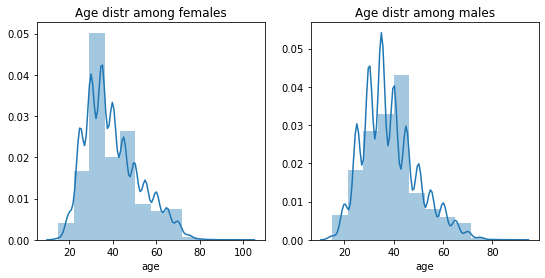

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

female = df_socdem[df_socdem['gender_cd'] == 0]
male = df_socdem[df_socdem['gender_cd'] == 1]

sns.distplot(female['age'], bins=12 ,ax=ax1)
sns.distplot(male['age'], bins=12, ax=ax2)

ax1.set_title('Age distr among females');
ax2.set_title('Age distr among males');

Добавим категориальный признак AgeGroup, позволяющий разделить всех клиентов на 6 групп в соответствии с их возрастом:

In [ ]:
df_socdem.loc[(df_socdem.age < 21),  'AgeGroup'] = '0-21'
df_socdem.loc[(21 <= df_socdem.age),  'AgeGroup'] = '21-29'
df_socdem.loc[(30 <= df_socdem.age),  'AgeGroup'] = '30-40'
df_socdem.loc[(41 <= df_socdem.age),  'AgeGroup'] = '41-54'
df_socdem.loc[(54 <= df_socdem.age),  'AgeGroup'] = '55-65'
df_socdem.loc[(65 <= df_socdem.age),  'AgeGroup'] = '65+'

In [ ]:
df_socdem

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg,AgeGroup
0,61243,0,70.0,0,0,0,65+
1,66535,0,25.0,0,0,0,21-29
2,83721,1,55.0,3,0,0,55-65
3,88238,0,35.0,0,0,0,30-40
4,57179,0,30.0,3,0,0,30-40
...,...,...,...,...,...,...,...
49995,54994,1,40.0,3,0,0,30-40
49996,63391,1,35.0,6,0,0,30-40
49997,5418,0,55.0,6,0,0,55-65
49998,50273,0,35.0,3,0,0,30-40


Удалим теперь ненужный признак Age:

In [ ]:
df_socdem = df_socdem.drop('age', axis=1)

##### Приведение категориальных признаков к числовому виду <a class="anchor" id="ch2222"></a>

In [ ]:
# AgeGroup - категориальный признак, переведем его в тип int
le_age = preprocessing.LabelEncoder()
le_age.fit(df_socdem['AgeGroup'])
df_socdem['AgeGroup'] = le_age.transform(df_socdem['AgeGroup'])

Заменим пропуски в колонке 'marital_status_desc' на значение None, так как, возможно, пользователь не захотел указывать свой статус

In [ ]:
df_socdem['gender_cd'] = df_socdem['gender_cd'].fillna('None')
df_socdem['marital_status_desc'] = df_socdem['marital_status_desc'].fillna('None')

In [ ]:
# marital_status_desc - категориальный признак, переведем его в тип int
le_mstatus = preprocessing.LabelEncoder()
le_mstatus.fit(df_socdem['marital_status_desc'])
df_socdem['marital_status_desc'] = le_mstatus.transform(df_socdem['marital_status_desc'])

In [ ]:
df_socdem['marital_status_desc'].value_counts().reset_index()

,index,marital_status_desc
0,3,17446
1,6,13045
2,0,12406
3,5,3696
4,2,2607
5,1,798
6,4,2


In [ ]:
# gender_cd - категориальный признак, переведем его в тип int
le_gender = preprocessing.LabelEncoder()
le_gender.fit(df_socdem['gender_cd'])
df_socdem['gender_cd'] = le_gender.transform(df_socdem['gender_cd'])

In [ ]:
df_socdem

,party_rk,gender_cd,marital_status_desc,children_cnt,region_flg,AgeGroup
0,61243,0,0,0,0,5
1,66535,0,0,0,0,1
2,83721,1,3,0,0,4
3,88238,0,0,0,0,2
4,57179,0,3,0,0,2
...,...,...,...,...,...,...
49995,54994,1,3,0,0,2
49996,63391,1,6,0,0,2
49997,5418,0,6,0,0,4
49998,50273,0,3,0,0,2


##### Заполнение пропусков <a class="anchor" id="ch2223"></a>

In [ ]:
print("\nКоличество пропущенных значений:")
df_socdem.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,party_rk,gender_cd,marital_status_desc,children_cnt,region_flg,AgeGroup
0,0,0,0,0,0,0


### df_balance <a class="anchor" id="ch223"></a>

В данной таблице содержится ежемесячная информация о изменениях баланса клиентов, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>account_rk</strong> - уникальный идентификационный номер счета</li>
<li><strong>prev_month</strong> - дата последнего дня (t-1)-го месяца в формате ГГГГ-ММ-ДД</li>
<li><strong>cur_month</strong> - дата последнего дня t-го месяца в формате ГГГГ-ММ-ДД</li>
<li><strong>balance_chng</strong> - изменение баланса в течение периода времени [prev_month, cur_month]</li>
</ul>
<strong>Первичный ключ</strong> таблицы является составным из двух атрибутов: account_rk + prev_month.

In [5]:
df_balance.head()

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0


##### Первичный анализ <a class="anchor" id="ch2231"></a>

In [6]:
print('Количество строк: {}, количество столбцов: {}'.format(df_balance.shape[0], df_balance.shape[1]))

Количество строк: 614434, количество столбцов: 5


In [7]:
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614434 entries, 0 to 614433
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   party_rk      614434 non-null  int64  
 1   account_rk    614434 non-null  int64  
 2   prev_month    612832 non-null  object 
 3   cur_month     612832 non-null  object 
 4   balance_chng  612832 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 23.4+ MB


In [8]:
df_balance

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0
...,...,...,...,...,...
614429,13734,124222,NaN,NaN,NaN
614430,33502,125615,NaN,NaN,NaN
614431,8735,123871,NaN,NaN,NaN
614432,91302,122557,NaN,NaN,NaN


Заметим, что у признаков 'prev_month' и 'cur_month', которые представляют из себя даты, тип object, хотя должен быть тип datetime.

In [9]:
df_balance['prev_month'] = pd.to_datetime(df_balance['prev_month'])
df_balance['cur_month'] = pd.to_datetime(df_balance['cur_month'])

In [10]:
df_balance = df_balance.drop(['account_rk'], axis = 1)

In [11]:
# def get_prev_or_cur_month(row):
#     if row['prev_month'] == np.nan and row['cur_month'] == np.nan:
#         return row
#     elif row['prev_month'] == np.nan:
#         row['prev_month'] =  pd.to_datetime(row['cur_month']) - pd.to_timedelta('1 month')
#         return row
#     elif row['cur_month'] == np.nan:
#         row['cur_month'] =  pd.to_datetime(row['prev_month']) + pd.to_timedelta('1 month')
#         return row
#     else:
#         return row

In [12]:
# df_balance.apply(lambda row: get_prev_or_cur_month(row),axis=1).info()

##### Заполнение пропусков <a class="anchor" id="ch2233"></a>

In [13]:
df_balance = df_balance.dropna(subset=["prev_month"],axis =0)
df_balance = df_balance.dropna(subset=["cur_month"],axis = 0)

In [14]:
df_balance

,party_rk,prev_month,cur_month,balance_chng
0,51607,2018-12-31,2019-01-31,15000.0
1,59074,2018-12-31,2019-01-31,0.0
2,33941,2018-12-31,2019-01-31,-15000.0
3,9336,2018-12-31,2019-01-31,-50000.0
4,13958,2018-12-31,2019-01-31,-20000.0
...,...,...,...,...
614418,61783,2019-11-30,2019-12-31,-25000.0
614419,73974,2019-11-30,2019-12-31,-20000.0
614420,34789,2019-11-30,2019-12-31,0.0
614421,15325,2019-11-30,2019-12-31,0.0


In [15]:
df_balance['pos_change'] = df_balance['balance_chng'].apply(lambda x: x if x>= 0 else x * -1)

In [29]:
df_balance,_,len_out = removing_outliers('pos_change',df_balance)



  0%|          | 0/612832 [00:00<?, ?it/s]

  0%|          | 224/612832 [00:00<04:34, 2231.75it/s]

  0%|          | 448/612832 [00:00<04:39, 2187.80it/s]

  0%|          | 774/612832 [00:00<03:49, 2670.25it/s]

  0%|          | 1066/612832 [00:00<03:41, 2767.97it/s]

  0%|          | 1344/612832 [00:00<03:55, 2591.19it/s]

  0%|          | 1606/612832 [00:00<04:14, 2397.61it/s]

  0%|          | 1972/612832 [00:00<03:40, 2764.98it/s]

  0%|          | 2254/612832 [00:00<03:54, 2605.21it/s]

  0%|          | 2588/612832 [00:00<03:37, 2810.47it/s]

  0%|          | 2875/612832 [00:01<03:56, 2576.76it/s]

  1%|          | 3140/612832 [00:01<04:03, 2502.05it/s]

  1%|          | 3537/612832 [00:01<03:30, 2894.82it/s]

  1%|          | 3834/612832 [00:01<03:37, 2794.11it/s]

  1%|          | 4119/612832 [00:01<03:53, 2606.05it/s]

  1%|          | 4452/612832 [00:01<03:39, 2773.18it/s]

  1%|          | 4735/612832 [00:01<03:45, 2698.57it/s]

  1%|          | 5021/612832 [00:01<03:42, 27

KeyboardInterrupt: ignored

### df_stories_texts <a class="anchor" id="ch224"></a>

В данной таблице содержится информация об историях, выкладываемых Тинькоффом, где
<ul>
<li><strong>story_id</strong> - уникальный идентификационный номер истории</li> 
<li><strong>name</strong> - заголовок истории</li>
<li><strong>story_text</strong> - текст истории</li>
</ul>
<strong>Первичным ключом</strong> таблицы является атрибут story_id.

In [ ]:
df_story_texts.head()

,story_id,name,story_text
0,794,Профессия: свадебный организатор,"["""",""Как стать свадебным организатором"",""Это Л..."
1,821,Бизнес: магазин электроники,"["""",""Как открыть интернет-магазин электроники""..."
2,824,Как у них: Сингапур,"["""",""Жизнь в Сингапуре"",""Это Славина. Вместе с..."
3,839,Студии йоги,"["""",""Студии йоги"",""7 московских студий, где мо..."
4,848,Как получать больше кэшбэка,"["""",""Как получать больше кэшбэка"",""Подключите ..."


##### Первичный анализ <a class="anchor" id="ch2241"></a>

In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_story_texts.shape[0], df_story_texts.shape[1]))

Количество строк: 1631, количество столбцов: 3


In [ ]:
df_story_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   story_id    1631 non-null   int64 
 1   name        1401 non-null   object
 2   story_text  1631 non-null   object
dtypes: int64(1), object(2)
memory usage: 38.4+ KB


##### Заполнение пропусков <a class="anchor" id="ch2243"></a>

In [ ]:
df_story_texts['name'] = df_story_texts['name'].fillna('None')

In [ ]:
print("\nКоличество пропущенных значений:")
df_story_texts.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,story_id,name,story_text
0,0,0,0


### df_stories_logs <a class="anchor" id="ch225"></a>

В данной таблице содержится информация о действиях клиентов относительно историй, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>date_time</strong> - дата и время действия клиента в формате ГГГГ-ММ-ДД ЧЧ:ММ:СС </li>
<li><strong>story_id</strong> - уникальный идентификационный номер истории</li>
<li><strong>category</strong> - уникальный идентификационный номер категории действия</li>
<li><strong>event</strong> - наименование действия (like / dislike / ...)</li>
</ul>
<strong>Первичный ключ</strong> таблицы является составным из двух атрибутов: party_rk + date_time.

In [ ]:
df_stories_logs.head()

,party_rk,date_time,story_id,category,event
0,64266,2019-12-01 13:05:31,3840,39,like
1,55721,2019-12-01 13:18:08,3857,39,like
2,27563,2019-12-01 13:25:40,3174,78,like
3,61223,2019-12-01 13:25:20,3857,39,like
4,61223,2019-12-01 13:29:05,3765,73,like


##### Первичный анализ <a class="anchor" id="ch2251"></a>

In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_stories_logs.shape[0], df_stories_logs.shape[1]))

Количество строк: 13820, количество столбцов: 5


In [ ]:
df_stories_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13820 entries, 0 to 13819
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   party_rk   13820 non-null  int64 
 1   date_time  13820 non-null  object
 2   story_id   13820 non-null  int64 
 3   category   13820 non-null  int64 
 4   event      13820 non-null  object
dtypes: int64(3), object(2)
memory usage: 540.0+ KB


Заметим, что у признака 'date_time', который представляет из себя дату, тип object, хотя должен быть тип datetime.

In [ ]:
df_stories_logs['date_time'] = pd.to_datetime(df_stories_logs['date_time'])

In [ ]:
df_stories_logs['event'].value_counts().reset_index()

,index,event
0,like,5920
1,favorite,5028
2,dislike,763
3,14],592
4,77],551
5,153,208
6,180,108
7,177,99
8,176,72
9,54],54


Удалим строки с непонятными (числовыми) значениями по признаку 'index' 

In [ ]:
df_stories_logs = df_stories_logs[(df_stories_logs['event'] == 'like') | (df_stories_logs['event'] =='dislike') | (df_stories_logs['event'] =='favorite')] 

##### Приведение категориальных признаков к числовому виду <a class="anchor" id="ch2252"></a>

In [ ]:
# event - категориальный признак, переведем его в тип int
le_event = preprocessing.LabelEncoder()
le_event.fit(df_stories_logs['event'])
df_stories_logs['event'] = le_event.transform(df_stories_logs['event'])

In [ ]:
df_stories_logs['event'].unique()

array([2, 1, 0])

In [ ]:
df_stories_logs

,party_rk,date_time,story_id,category,event
0,64266,2019-12-01 13:05:31,3840,39,2
1,55721,2019-12-01 13:18:08,3857,39,2
2,27563,2019-12-01 13:25:40,3174,78,2
3,61223,2019-12-01 13:25:20,3857,39,2
4,61223,2019-12-01 13:29:05,3765,73,2
...,...,...,...,...,...
13815,19043,2019-12-31 22:52:40,4117,71,2
13816,19043,2019-12-31 22:53:13,4120,39,2
13817,10195,2019-12-31 23:32:50,4117,71,1
13818,10195,2019-12-31 23:33:32,4120,39,2


##### Заполнение пропусков <a class="anchor" id="ch2253"></a>

In [ ]:
print("\nКоличество пропущенных значений:")
df_stories_logs.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,party_rk,date_time,story_id,category,event
0,0,0,0,0,0


### df_products <a class="anchor" id="ch226"></a>

В данной таблице содержится информация о связи пользователей с некоторыми категориями продуктов, где
<ul>
<li><strong>party_rk</strong> - уникальный идентификационный номер клиента</li> 
<li><strong>product1 - ... - product7</strong> - бинарные признаки связи пользователя и соответствующего продукта </li>
</ul>
<strong>Первичным ключом</strong> таблицы является атрибут party_rk.

In [ ]:
df_products.head()

,party_rk,product1,product2,product3,product4,product5,product6,product7
0,74874,1,1,0,0,0,0,0
1,83618,0,0,1,1,1,0,0
2,73766,0,0,0,1,1,0,0
3,60218,0,1,0,0,0,0,0
4,47253,0,0,0,1,1,0,0


##### Первичный анализ <a class="anchor" id="ch2261"></a>

In [ ]:
print('Количество строк: {}, количество столбцов: {}'.format(df_products.shape[0], df_products.shape[1]))

Количество строк: 50000, количество столбцов: 8


In [ ]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   party_rk  50000 non-null  int64
 1   product1  50000 non-null  int64
 2   product2  50000 non-null  int64
 3   product3  50000 non-null  int64
 4   product4  50000 non-null  int64
 5   product5  50000 non-null  int64
 6   product6  50000 non-null  int64
 7   product7  50000 non-null  int64
dtypes: int64(8)
memory usage: 3.1 MB


##### Заполнение пропусков <a class="anchor" id="ch2263"></a>

In [ ]:
print("\nКоличество пропущенных значений:")
df_products.isna().sum().to_frame().sort_values(0, ascending = False).T


Количество пропущенных значений:


,party_rk,product1,product2,product3,product4,product5,product6,product7
0,0,0,0,0,0,0,0,0


## Создание единой таблицы <a class="anchor" id="ch3"></a>

In [ ]:
# HardCoded creation of dates [first date in every month of 2019]
unique_dates = np.array(['2019-01-01T00:00:00.000000000', '2019-02-01T00:00:00.000000000',
       '2019-03-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2019-05-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2019-08-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

# Constructing DataFrame of every possible combination tripplet (month,category,human)
# through Cartesian product [dates * categories * people_id] 
# There should be 12*37*50000 = 22 200 000 of such triplets

u_dat = pd.DataFrame(unique_dates, columns=['transaction_dttm'])
u_cat= pd.DataFrame(df_train.category.unique(), columns=['category'] )
u_id = pd.DataFrame(df_train.party_rk.unique(), columns=['party_rk'] )

u_dat['key'] = 1
u_cat['key'] = 1
u_id['key'] = 1

df_train2 = pd.merge(u_id, 
                  pd.merge(u_dat, u_cat, on ='key')).drop("key", 1)

# Added zero column for further easy concatation 
df_train2['transaction_amt_rur'] = 0
df_train2.info()

In [ ]:
# Creating minimal sized DataFrame with columns = (transaction_dttm, human_id, category, price)
# Every month for every human should have all 37 categories

# This implemetation adds 0 expenditure for every month beginning to the main training DataFrame
df_main = df_train[['transaction_dttm', 'party_rk', 'category', 'transaction_amt_rur']]
df_main = pd.concat([df_main,df_train2])
df_main.info()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_main_sort = df_main.sort_values(by=['transaction_dttm','party_rk'])
df_main_sort.head(100)

In [ ]:
df_socdem_train = df_main_sort.merge(df_socdem, on = 'party_rk', how = 'left')

In [ ]:
df_socdem_train_bal = df_socdem_train.merge(df_balance, on = 'party_rk', how = 'left')

In [ ]:
df_temp = df_socdem_train_bal.merge(df_products, on = 'party_rk', how = 'left')

In [ ]:
df_temp1 = df_temp.merge(df_stories_logs,on = 'party_rk', how = 'left')

In [ ]:
df_final = df_temp1.merge(story_texts, on = 'story_id', how = 'left')

Альтернативно можно намного быстрее так выполнить left join


In [ ]:
df_socdem_train = pd.concat(
    [
     df_main_sort                                      .reset_index(drop=True), 
     df_socdem.reindex(df_main_sort['party_rk'].values).reset_index(drop=True)
     ], 
     axis=1)

## Визуализация данных  <a class="anchor" id="ch4"></a>

In [ ]:
df_cluster = pd.merge(df_train, df_socdem)

In [ ]:
df_category_trans = df_cluster.groupby("category")['transaction_amt_rur'].sum().reset_index().sort_values(by = 'transaction_amt_rur', ascending = False)

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x="transaction_amt_rur", y="category", data=df_category_trans, orient = 'h');

In [ ]:
df_distr = pd.pivot_table(data = df_cluster[['age', 'transaction_amt_rur', 'children_cnt', 'gender_cd', 'category']], index = ['gender_cd', 'category'])

In [ ]:
df_distr = df_distr.reset_index()

In [ ]:
plt.figure(figsize=(16,10))
sns.lineplot(data= df_distr, x=df_distr['category'], y=df_distr['transaction_amt_rur'], hue=df_distr['gender_cd'])
plt.xticks(rotation=90);